# AeroLunar: Predicting Air Quality with Lunar Cycles

*Datasets from:*
 
*https://data.gov.hk/en-data/dataset/hk-epd-airteam-past-record-of-air-quality-health-index-en (air quality health index)*

*https://www.somacon.com/p570.php (moon phase)*

*https://cd.epic.epd.gov.hk/EPICDI/air/station/ (pollutants)*


*More detailed data cleaning steps in [clean.ipynb](clean.ipynb)*

***Outline:***
1. **Data Preprocessing**
  - 1.1 Select the required data
  - 1.2 Check for outliers using visualization
  - 1.3 Standardization

2. **Exploratory Data Analysis**
  - 2.1 Comparison of AQHI across Pre-, In-, and Post-Pandemic periods
  - 2.2 ANOVA and Tukey's HSD tests
    
3. **Feature Engineering**
  - 3.1 Pairplot to visualize the trend
  - 3.2 Correlation Matrix
  - 3.3 Further preprocessing to resolve collinearity

4. **Data preprocessing for time-series**
  - 4.1 Create Sequences for Time-series Analysis
  - 4.2 Data Splitting

5. **SARIMAX - Statistical Learning Model**
  - 5.1 Converting sequences to DataFrame
  - 5.2 Time Series Diagnostics
    - 5.2.1 Checking for stationarity
    - 5.2.2 Detecting seasonality
  - 5.3 Statistical Interpretation
    - 5.3.1 Hyperparameter Tuning with Auto-ARIMA
    - 5.3.2 Model fitting & residual analysis with Moon Phase
    - 5.3.3 Model fitting & residual analysis without Moon Phase
  - 5.4 Model Testing
    - 5.4.1 Prediction with Moon Phase
    - 5.4.2 Prediction without Moon Phase

6. **LSTM - Deep Learning Model**
  - 6.1 Converting data to tensors
  - 6.2 Model Architecture
  - 6.3 Hyperparameter Tuning with Cross-validation
    - 6.3.1 Implement the GridSearchCV function
    - 6.3.2 Model fitting with Moon Phase
    - 6.3.3 Model fitting without Moon Phase
  - 6.4 Model Testing
    - 6.4.1 Prediction with Moon Phase
    - 6.4.2 Prediction without Moon Phase

7. **Conclusion**
  - 7.1 Performance Comparison
  - 7.2 Limitations
  - 7.3 Improvement
  - 7.4 Summary

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import itertools
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')

# set random seed to 42 for reproducibility
SEED = 42

def set_seed(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

set_seed(SEED)

## 1. Data Preprocessing

### 1.1 Select the required data

In [155]:
# read the file
df = pd.read_csv("cleaned_data.csv")
df.head()

,Date,Hour,Location,AQHI,phase,phaseid,SO2,NOX,NO2,CO,RSP,O3,FSP
0,2014-01-01,1,Central/Western,6.0,New Moon,1.0,41.0,111.000000,104.0,90.001010,126.0,34.0,94.0
1,2014-01-01,1,Eastern,7.0,New Moon,1.0,50.0,89.003674,175.0,134.250757,107.0,8.0,71.0
2,2014-01-01,1,Kwun Tong,9.0,New Moon,1.0,52.0,792.000000,217.0,222.750252,150.0,5.5,111.0
3,2014-01-01,1,Sham Shui Po,8.0,New Moon,1.0,41.0,529.000000,178.0,96.999909,140.0,5.0,102.0
4,2014-01-01,1,Kwai Chung,6.0,New Moon,1.0,27.0,250.000000,136.0,178.500505,115.0,5.0,91.0


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104432 entries, 0 to 1104431
Data columns (total 13 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Date      1104432 non-null  object 
 1   Hour      1104432 non-null  int64  
 2   Location  1104432 non-null  object 
 3   AQHI      1104432 non-null  float64
 4   phase     1104432 non-null  object 
 5   phaseid   1104432 non-null  float64
 6   SO2       1104432 non-null  float64
 7   NOX       1104432 non-null  float64
 8   NO2       1104432 non-null  float64
 9   CO        1104432 non-null  float64
 10  RSP       1104432 non-null  float64
 11  O3        1104432 non-null  float64
 12  FSP       1104432 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 109.5+ MB


In [157]:
# convert to datetime
df['Date'] = pd.to_datetime(df['Date']) #format='%d/%m/%Y', dayfirst=True

# drop phase column
df.drop(columns="phase", inplace=True)

# focus on sham shui po and get the daily meaan
df = df[df["Location"] == "Sham Shui Po"]
df.drop(columns="Location", inplace=True)

df = df.groupby("Date").mean().reset_index()

# drop hour column
df.drop(columns="Hour", inplace=True)
df

,Date,AQHI,phaseid,SO2,NOX,NO2,CO,RSP,O3,FSP
0,2014-01-01,6.708333,1.0,28.458333,265.250000,145.125000,96.998859,100.416667,32.625000,73.666667
1,2014-01-02,5.958333,1.0,19.416667,191.458333,131.708333,96.996669,85.166667,27.541667,62.916667
2,2014-01-03,7.208333,1.0,46.541667,400.375000,178.583333,96.994478,117.125000,13.375000,81.666667
3,2014-01-04,7.125000,1.0,34.000000,133.375000,105.166667,96.992287,126.500000,67.333333,95.875000
4,2014-01-05,7.208333,1.0,31.833333,95.000000,80.166667,96.990097,129.916667,93.416667,93.166667
...,...,...,...,...,...,...,...,...,...,...
3282,2022-12-27,4.500000,1.0,4.166667,55.000000,45.666667,83.959775,31.166667,88.041667,17.583333
3283,2022-12-28,4.791667,1.0,5.083333,61.291667,52.083333,83.968672,40.125000,84.416667,22.583333
3284,2022-12-29,4.666667,1.0,5.250000,63.250000,52.791667,83.977570,57.916667,70.500000,40.500000
3285,2022-12-30,3.791667,2.0,2.666667,58.416667,45.916667,83.986468,41.375000,58.166667,33.208333


### 1.2 Check for outliers

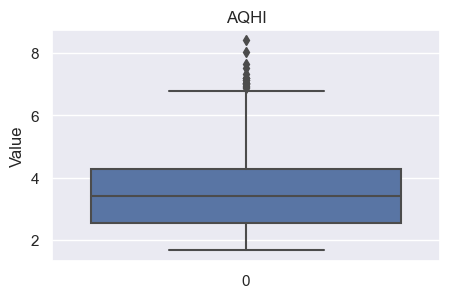

In [158]:
# AQHI
plt.figure(figsize=(5, 3))
sns.boxplot(data=df['AQHI'])
plt.title('AQHI')
plt.ylabel('Value')
plt.show()

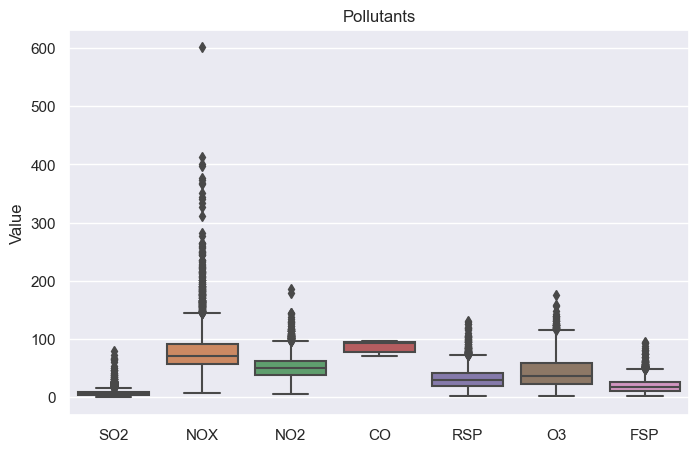

In [159]:
# Pollutants
plt.figure(figsize=(8, 5))
sns.boxplot(data=df.drop(columns=["Date", "AQHI", "phaseid"]))
plt.title('Pollutants')
plt.ylabel('Value')
plt.show()

### 1.3 Standardization

In [160]:
scaler = StandardScaler()

# standardize the features
df[df.columns[1:]] = scaler.fit_transform(df[df.columns[1:]])
df

,Date,AQHI,phaseid,SO2,NOX,NO2,CO,RSP,O3,FSP
0,2014-01-01,2.864463,-1.332429,3.426052,4.616860,4.910234,1.075668,3.990529,-0.403488,4.411515
1,2014-01-02,2.193987,-1.332429,1.918744,2.775241,4.200515,1.075427,3.092450,-0.596042,3.523419
2,2014-01-03,3.311447,-1.332429,6.440667,7.989176,6.680124,1.075186,4.974490,-1.132669,5.072423
3,2014-01-04,3.236950,-1.332429,4.349885,1.325654,2.796506,1.074945,5.526588,0.911248,6.246224
4,2014-01-05,3.311447,-1.332429,3.988687,0.367929,1.474048,1.074704,5.727797,1.899273,6.022479
...,...,...,...,...,...,...,...,...,...,...
3282,2022-12-27,0.890285,-1.332429,-0.623535,-0.630351,-0.350944,-0.358860,-0.087633,1.695671,-0.221730
3283,2022-12-28,1.151025,-1.332429,-0.470720,-0.473330,-0.011513,-0.357881,0.439927,1.558357,0.191338
3284,2022-12-29,1.039279,-1.332429,-0.442936,-0.424456,0.025957,-0.356902,1.487686,1.031200,1.671498
3285,2022-12-30,0.257058,-0.442428,-0.873595,-0.545081,-0.337719,-0.355923,0.513540,0.564019,1.069107


## 2. Exploratory Data Analysis

### 2.1 Comparison of AQHI across Pre-, In-, and Post-Pandemic Periods

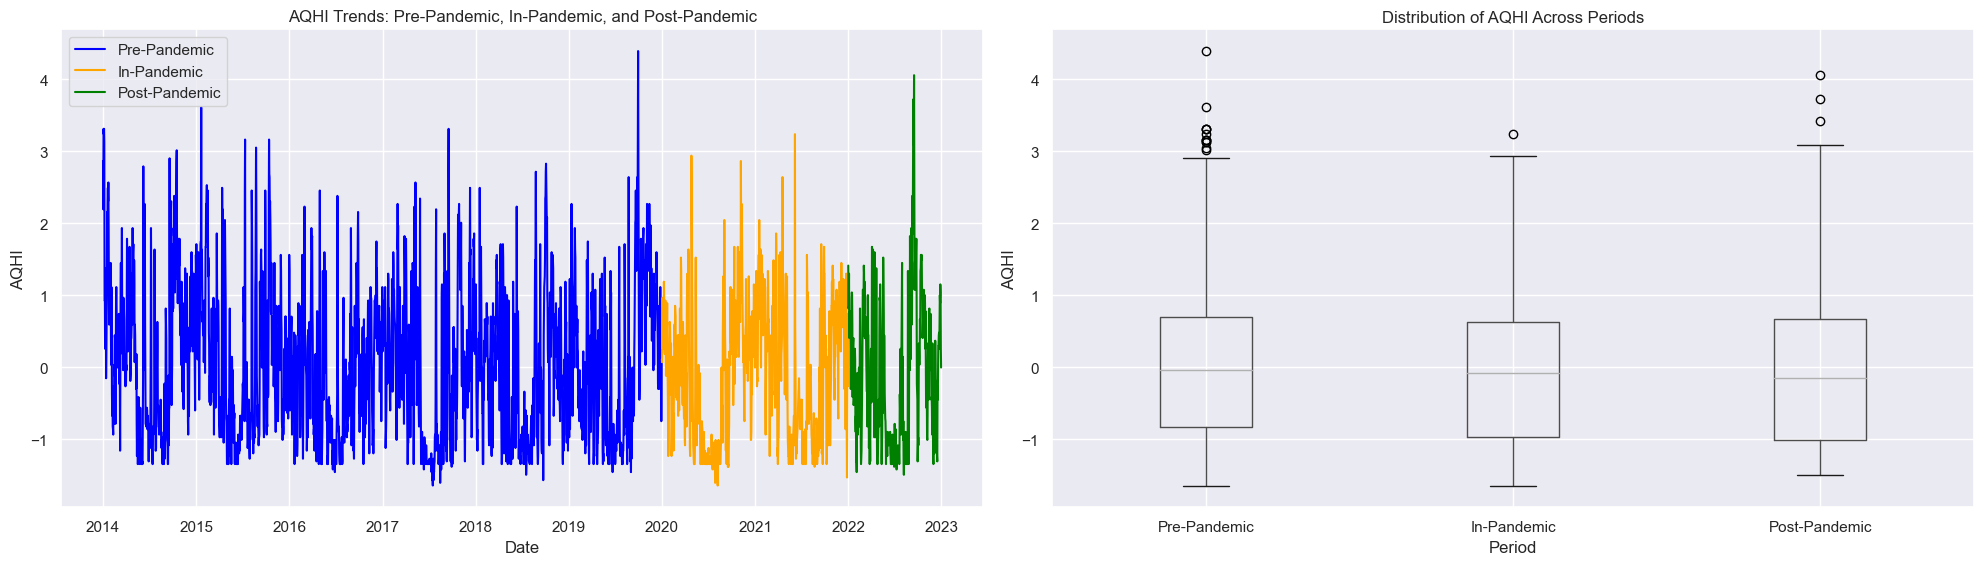

In [220]:
eda_df = df.copy()

# split
pre_pan = eda_df[eda_df['Date'] < '2020-01-01']
in_pan = eda_df[(eda_df['Date'] >= '2020-01-01') & (eda_df['Date'] <= '2021-12-31')]
post_pan = eda_df[eda_df['Date'] >= '2022-01-01']

# line plot
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0].plot(pre_pan['Date'], pre_pan['AQHI'], label='Pre-Pandemic', color='blue')
axs[0].plot(in_pan['Date'], in_pan['AQHI'], label='In-Pandemic', color='orange')
axs[0].plot(post_pan['Date'], post_pan['AQHI'], label='Post-Pandemic', color='green')

axs[0].set_title('AQHI Trends: Pre-Pandemic, In-Pandemic, and Post-Pandemic')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('AQHI')
axs[0].legend()
axs[0].grid(True)

# box plot
eda_df['Period'] = pd.cut(eda_df['Date'], 
                          bins=[pd.Timestamp('2013-12-31'), 
                                pd.Timestamp('2019-12-31'), 
                                pd.Timestamp('2021-12-31'), 
                                pd.Timestamp('2022-12-31')],
                          labels=['Pre-Pandemic', 'In-Pandemic', 'Post-Pandemic'])
eda_df.boxplot(column='AQHI', by='Period', ax=axs[1])

axs[1].set_title('Distribution of AQHI Across Periods')
axs[1].set_xlabel('Period')
axs[1].set_ylabel('AQHI')

plt.suptitle('')  
plt.tight_layout();

### 2.2 ANOVA and Tukey's HSD tests

In [226]:
# ANOVA test
aqhi_pre = pre_pan['AQHI']
aqhi_in = in_pan['AQHI']
aqhi_post = post_pan['AQHI']

f_stat, p_value = f_oneway(aqhi_pre, aqhi_in, aqhi_post)
print(f"ANOVA test:\nf-stat = {f_stat}, \np-value = {p_value}")

ANOVA test:
f-stat = 5.832896891939073, 
p-value = 0.0029600141629996936


There is significant evidence to support that there are differences in the mean of AQHI across different period as p-value < 0.05. 

Next, we run a Tukey's HSD test to identify which periods differ from each other.

In [222]:
# Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=eda_df['AQHI'],
                          groups=eda_df['Period'], 
                          alpha=0.05 # significance level
                          )

print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
  In-Pandemic Post-Pandemic   0.0055 0.9959 -0.1446 0.1556  False
  In-Pandemic  Pre-Pandemic    0.128 0.0076   0.028  0.228   True
Post-Pandemic  Pre-Pandemic   0.1225 0.0766 -0.0099 0.2549  False
-----------------------------------------------------------------


From the results, we can see that only in-pandemic and pre-pandemic periods differ from each other. 

Therefore, it is safe to say the effect of pandemic would not cause significant impact on the AQHI prediction results as we are taking mostly using pre-pandemic and one year of in-pandemic data (around 7 years/ 80% of the dataset) to predict one year of in-pandemic and the post-pandemic data (around 2 years/ 20% of the dataset).

## 3. Feature Engineering

### 3.1 Pairplot to visualize the trend

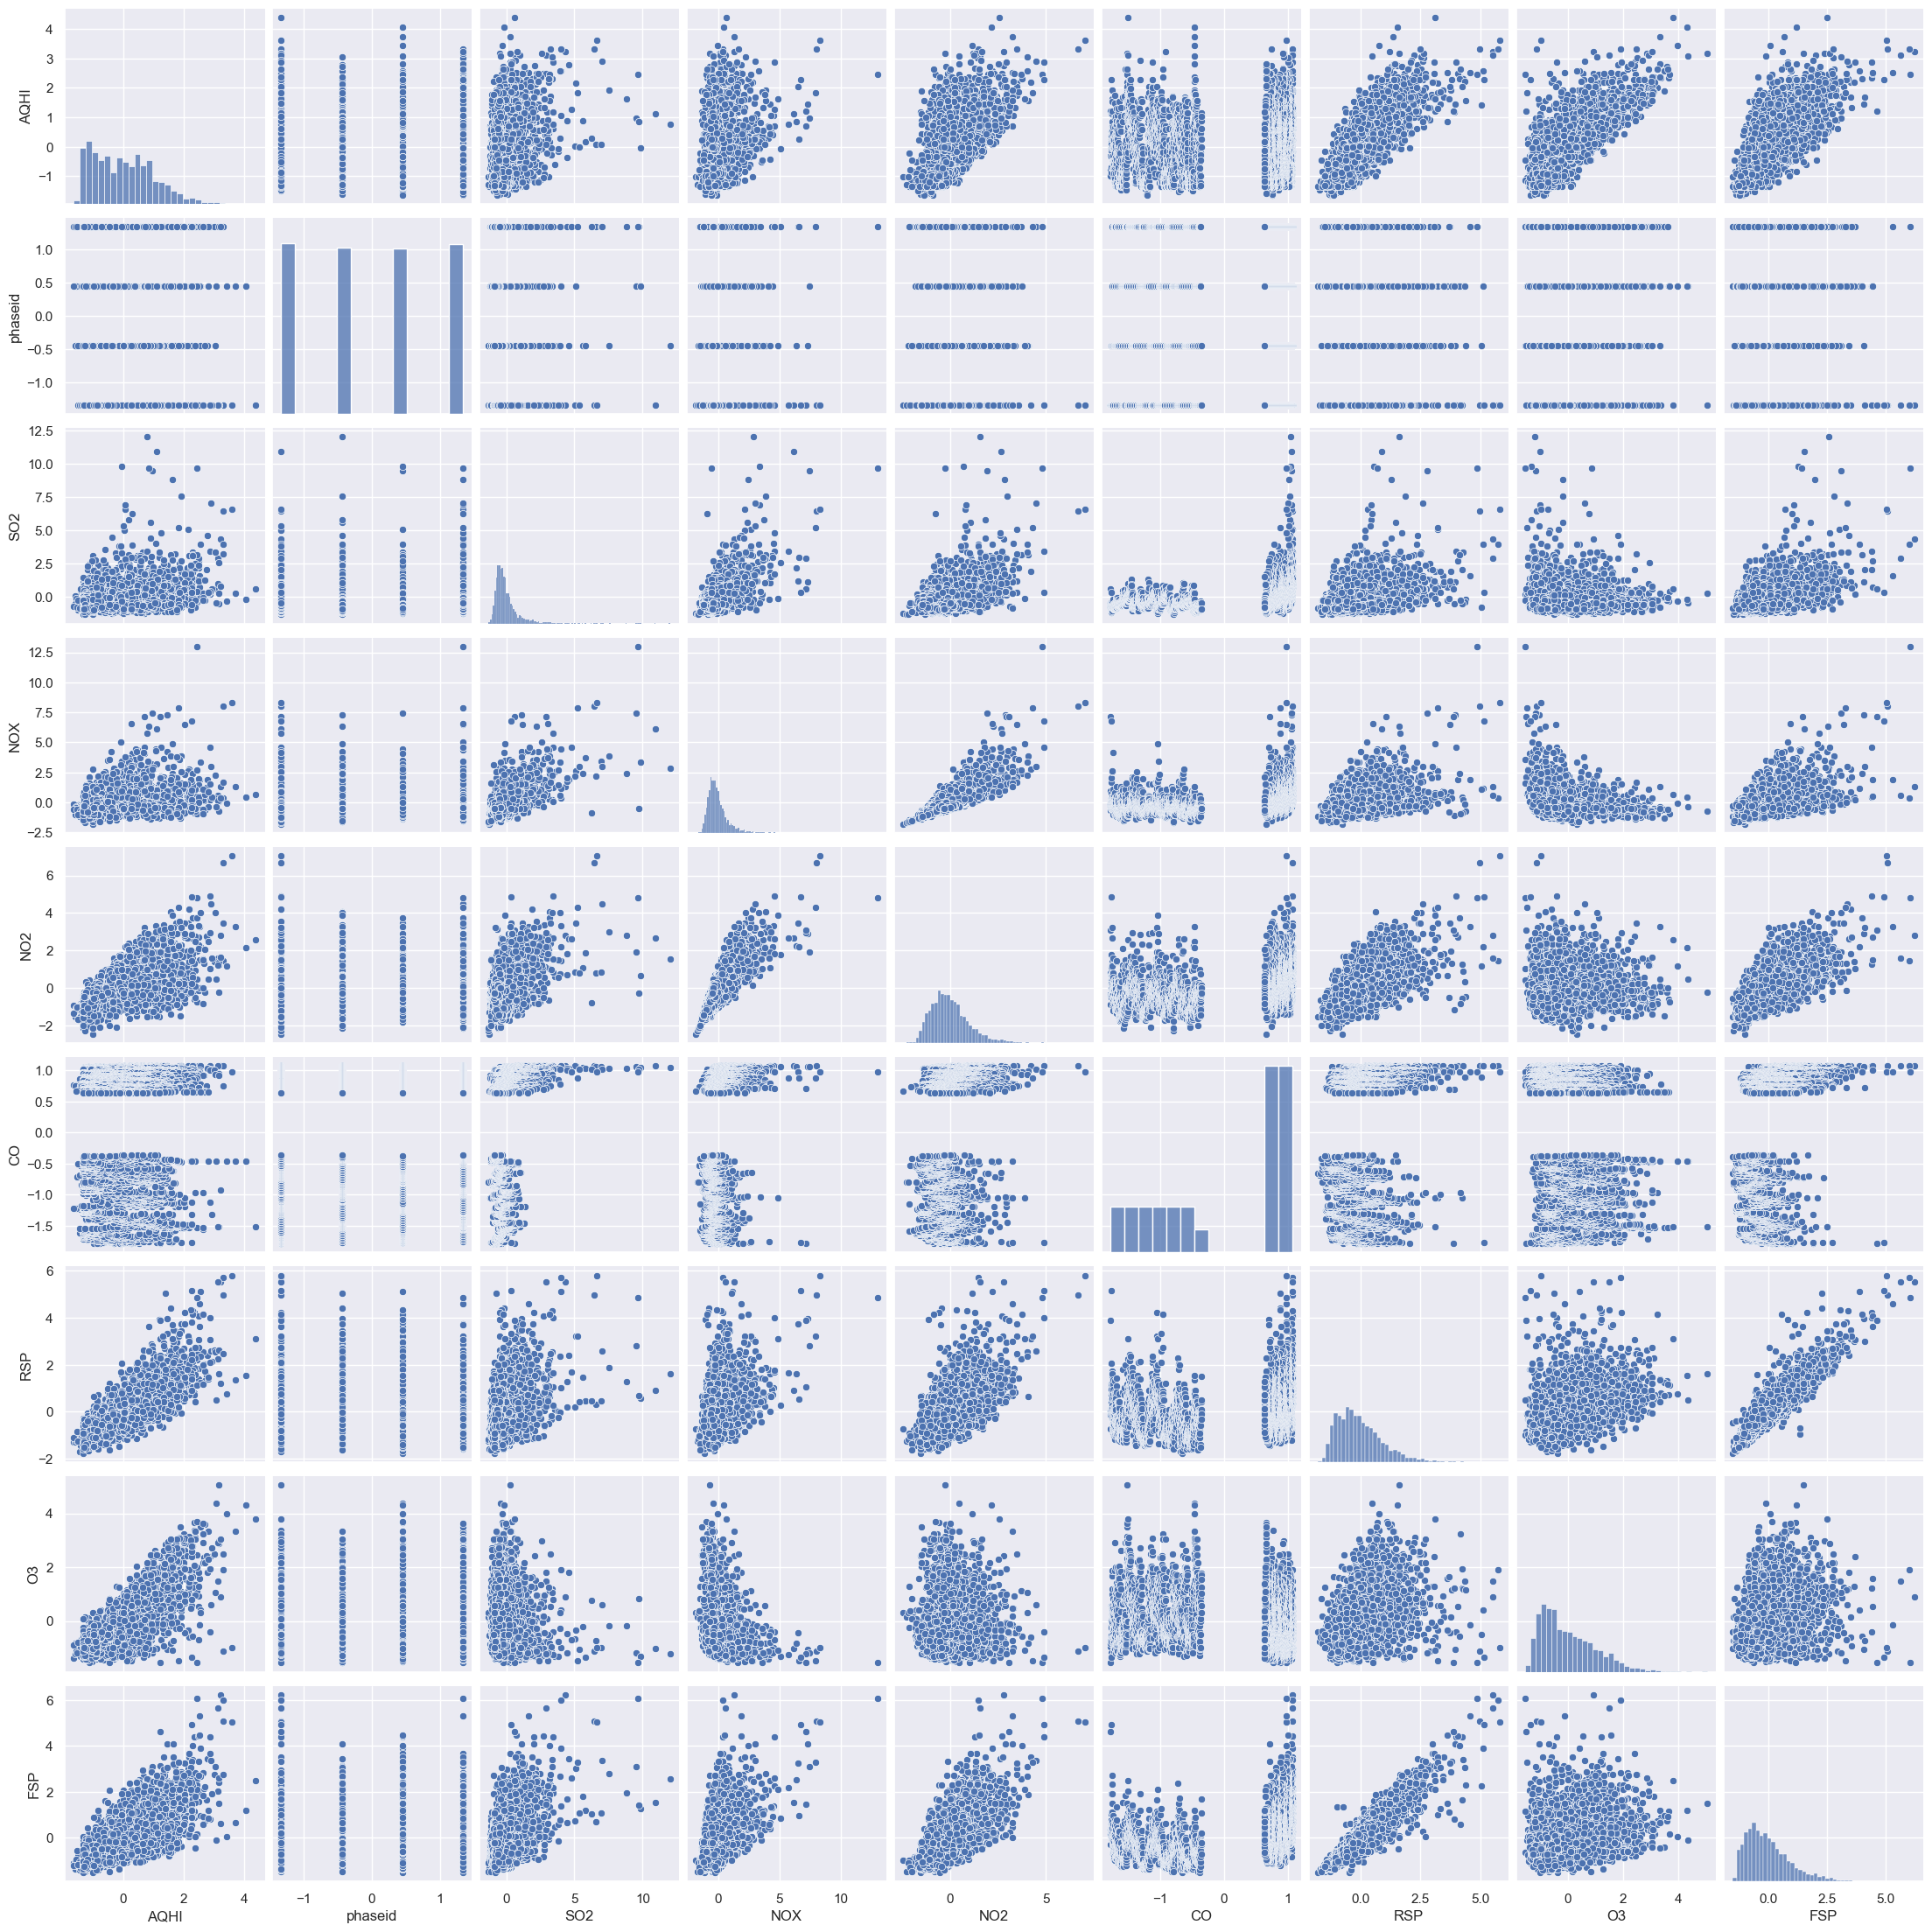

In [168]:
# see if there is any significant linear relationship from this plot
sns.pairplot(df.drop(columns="Date"));

### 3.2 Correlation Matrix

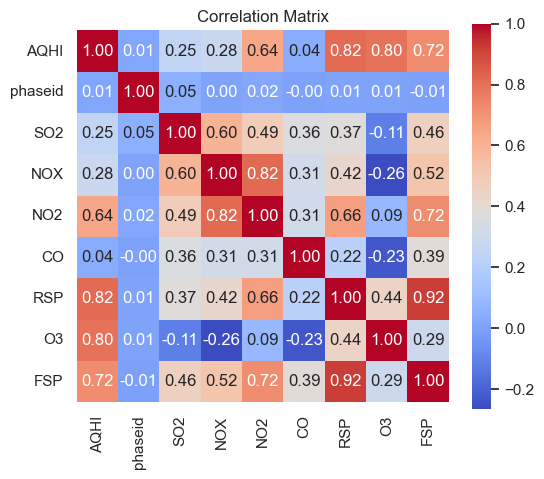

In [169]:
# get the correlation matrix
correlation_matrix = df.drop(columns="Date").corr()

# plot the matrix
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

### 3.3 Further Preprocessing to Resolve collinearity

NO2 vs NOX (0.82) -> keep NO2 since it has a higher 0.64 correlation with the target variable (AQHI)

FSP vs RSP (0.92) -> keep RSP since it has a higher 0.82 correlation with the target variable (AQHI)

In [170]:
# drop NOX and FSP
df.drop(columns=["NOX", "FSP"], inplace=True)

## 4. Data Preprocessing for time-series

### 4.1 Create Sequences for Time-series Analysis

In [171]:
# create sequences function
def create_sequences(features, target, seq_length):
    sequences = []
    labels = []
    for i in range(len(features) - seq_length):
        seq = features[i:i + seq_length]
        label = target[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)


# separate features (one with moonphase one without) and target
features = df.copy().drop(columns=['Date', 'AQHI'])
target = df.copy()['AQHI']

# features w/o moonphase
without_moonphase = features.drop(columns='phaseid')

# parameter for sequence length
SEQ_LENGTH = 5

X, y = create_sequences(features, target, SEQ_LENGTH)
X_without_mp, y = create_sequences(without_moonphase, target, SEQ_LENGTH)

### 4.2 Data Splitting

In [172]:
# 80% training, 20% testing
SPLIT_SIZE = 0.8
train_size = int(len(X) * SPLIT_SIZE)

X_train, X_test = X[:train_size], X[train_size:]
X_train_without_mp, X_test_without_mp = X_without_mp[:train_size], X_without_mp[train_size:]

y_train, y_test = y[:train_size], y[train_size:]

print(f"Size of X_train: {X_train.shape}")
print(f"Size of X_test: {X_test.shape}\n")

print(f"Size of X_train_without_mp: {X_train_without_mp.shape}")
print(f"Size of X_test_without_mp: {X_test_without_mp.shape}\n")

print(f"Size of y_train: {y_train.shape}")
print(f"Size of y_test: {y_test.shape}")

Size of X_train: (2625, 5, 6)
Size of X_test: (657, 5, 6)

Size of X_train_without_mp: (2625, 5, 5)
Size of X_test_without_mp: (657, 5, 5)

Size of y_train: (2625,)
Size of y_test: (657,)


## 5. SARIMAX - Statistical Learning Model

### 5.1 Converting sequences to DataFrame

In [173]:
# convert to df
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], -1),
                          columns=[f'feature_{i}' for i in range(X_train.shape[1] * X_train.shape[2])])
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], -1),
                         columns=[f'feature_{i}' for i in range(X_test.shape[1] * X_test.shape[2])])

X_train_without_mp_df = pd.DataFrame(X_train_without_mp.reshape(X_train_without_mp.shape[0], -1),
                          columns=[f'feature_{i}' for i in range(X_train_without_mp.shape[1] * X_train_without_mp.shape[2])])
X_test_without_mp_df = pd.DataFrame(X_test_without_mp.reshape(X_test_without_mp.shape[0], -1),
                         columns=[f'feature_{i}' for i in range(X_test_without_mp.shape[1] * X_test_without_mp.shape[2])])

y_train_df = pd.Series(y_train)
y_test_df = pd.Series(y_test)

### 5.2 Time Series Diagnostics

#### 5.2.1 Checking for stationarity

In [174]:
# ADF test
print("p-value =", adfuller(y_train_df)[1])

p-value = 1.287446182470633e-07


The data is stationary as p-value < 0.05.

#### 5.2.2 Detecting seasonality

In [175]:
# print the number of cycles for each time period
days = len(y_train_df)
weeks = days//7
months = days//30
quarters = days//90
years = days//365

print(f"We have approximately {days} days, {weeks} weeks, {months} months, {quarters} quarters or {years} years of data.")

We have approximately 2625 days, 375 weeks, 87 months, 29 quarters or 7 years of data.


We generally need to have >100 cycles of data to have a greater statistical significance, so we will be focusing on weekly trends.

We have 291 cycles of data with 9-day period.


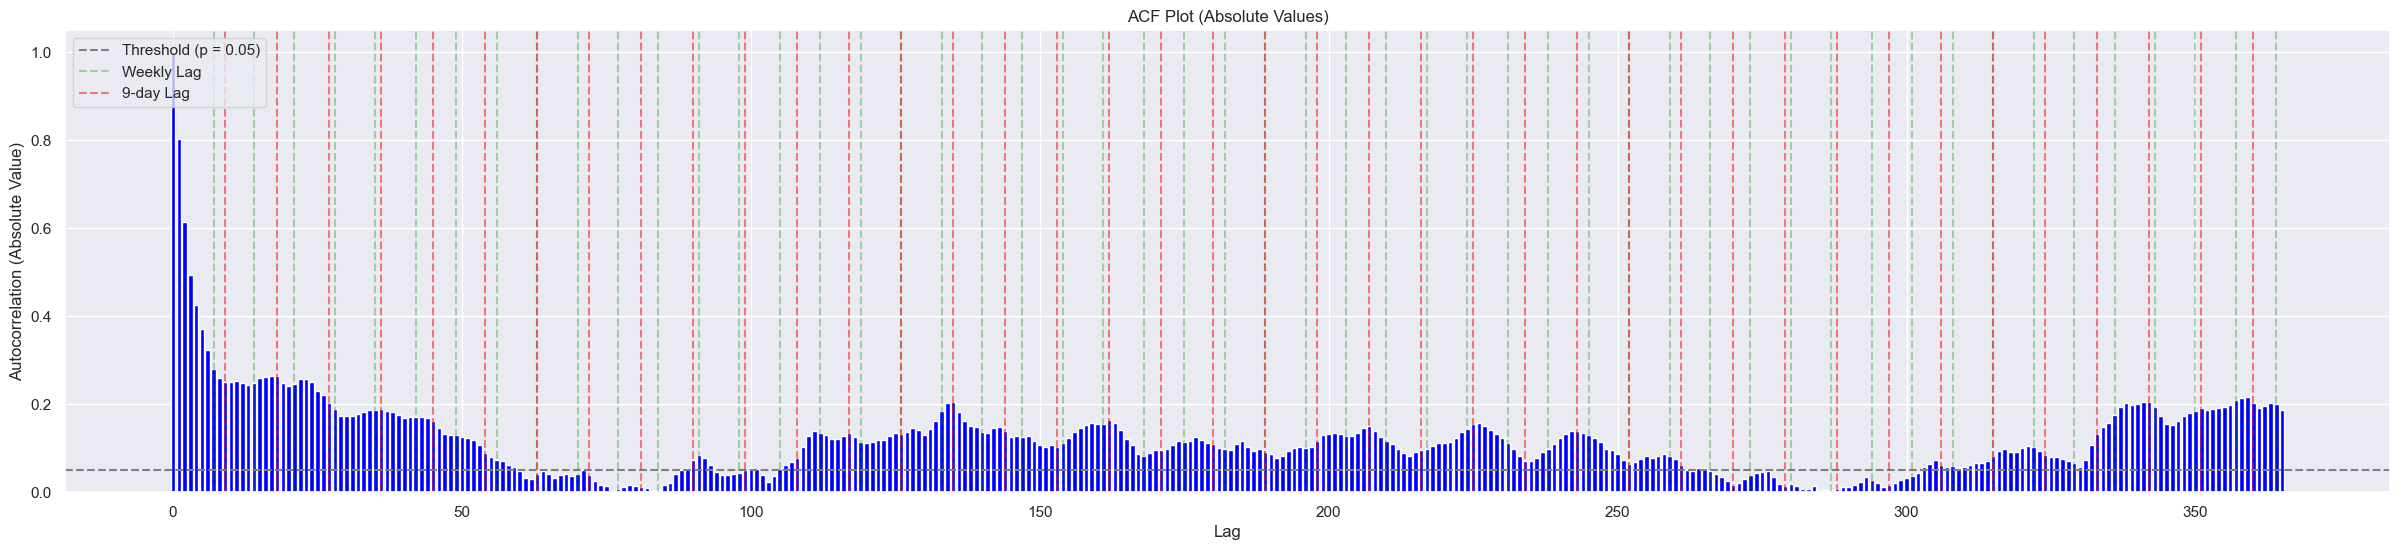

In [176]:
# ACF test
acf_values = acf(y_train_df, nlags=365)
absolute_acf_values = np.abs(acf_values)

lags = range(0, len(absolute_acf_values))

plt.figure(figsize=(30, 6))

plt.bar(lags, absolute_acf_values, color='blue')
plt.axhline(y=0.05, linestyle='--', color='gray', label='Threshold (p = 0.05)') # threshold -> p = 0.05

# weekly
for lag in range(7, 366, 7):
    plt.axvline(x=lag, linestyle='--', color='green', alpha=0.3, label='Weekly Lag' if lag == 7 else None)
# 9-day
for lag in range(9, 366, 9):
    plt.axvline(x=lag, linestyle='--', color='red', alpha=0.5, label='9-day Lag' if lag == 9 else None)

plt.legend()
plt.title("ACF Plot (Absolute Values)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation (Absolute Value)");

cycles = days//9
print(f"We have {cycles} cycles of data with 9-day period.")

The ACF plot shows that the correlation power peaks in every 9-day period (red dotted lines), so we are choosing 9 as our seasonality parameter.

### 5.3 Statistical Interpretation

#### 5.3.1 Hyperparameter Tuning with Auto-ARIMA

In [177]:
# auto ARIMA with exogenous variables
auto_arima = auto_arima(
    y = y_train_df,               
    X = X_train_df, 

    seasonal = True,            # include seasonal components
    m = 9,                      # seasonality parameter

    random = True,              # enable random search
    random_state = SEED,

    trace = True,               # print the details

    max_order = 3,              # maximum order for (p+q) and (P+Q)
    max_iterations = 5,         # 5 iterations per search

    n_jobs = -1                 # parallel processing
)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[9] intercept   : AIC=4479.033, Time=21.48 sec
 ARIMA(0,0,0)(0,0,0)[9] intercept   : AIC=4473.919, Time=1.53 sec
 ARIMA(1,0,0)(1,0,0)[9] intercept   : AIC=4470.169, Time=19.16 sec
 ARIMA(0,0,1)(0,0,1)[9] intercept   : AIC=4470.553, Time=21.82 sec
 ARIMA(0,0,0)(0,0,0)[9]             : AIC=4472.099, Time=3.49 sec
 ARIMA(1,0,0)(0,0,0)[9] intercept   : AIC=4469.078, Time=8.35 sec
 ARIMA(1,0,0)(0,0,1)[9] intercept   : AIC=4470.213, Time=18.87 sec
 ARIMA(1,0,0)(1,0,1)[9] intercept   : AIC=4472.926, Time=19.95 sec
 ARIMA(2,0,0)(0,0,0)[9] intercept   : AIC=4471.436, Time=10.65 sec
 ARIMA(1,0,1)(0,0,0)[9] intercept   : AIC=4471.016, Time=10.06 sec
 ARIMA(0,0,1)(0,0,0)[9] intercept   : AIC=4469.404, Time=10.12 sec
 ARIMA(2,0,1)(0,0,0)[9] intercept   : AIC=4473.224, Time=11.11 sec
 ARIMA(1,0,0)(0,0,0)[9]             : AIC=4467.286, Time=8.05 sec
 ARIMA(1,0,0)(1,0,0)[9]             : AIC=4468.384, Time=17.48 sec
 ARIMA(1,0,0)(0,0,1)[9]

The optimal hyperparameters are (p=1, d=0, q=0) (P=0, D=0, Q=0, s=9)

#### 5.3.2 Model fitting & residual analysis with Moon Phase

In [197]:
# fit the model
model = SARIMAX(y_train_df,
                exog=X_train_df,

                # hyperparameters: order (p, d, q) and seasonal order (P, D, Q, s)
                order=(1, 0, 0),
                seasonal_order=(0, 0, 0, 9))

model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2625
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2201.643
Date:                Sat, 28 Dec 2024   AIC                           4467.286
Time:                        22:51:19   BIC                           4655.217
Sample:                             0   HQIC                          4535.345
                               - 2625                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feature_0      0.0233      0.021      1.112      0.266      -0.018       0.064
feature_1     -0.0257      0.016     -1.609      0.108      -0.057       0.006
feature_2     -0.0173      0.019     -0.901      0.3

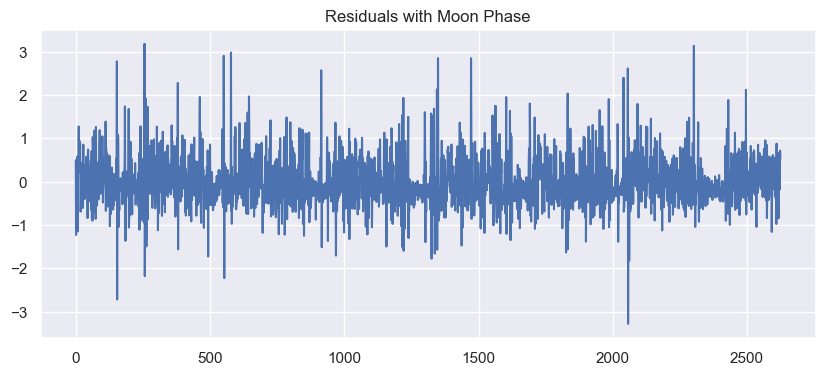

In [ ]:
# residual plot
residuals_with_mp = model_fit.resid

plt.figure(figsize=(10, 4))
plt.plot(residuals_with_mp)
plt.title("Residuals with Moon Phase");

#### 5.3.3 Model fitting & residual analysis without Moon Phase

In [199]:
# fit the model
model_without_mp = SARIMAX(y_train_df,
                           exog=X_train_without_mp_df,

                           # hyperparameters: order (p, d, q) and seasonal order (P, D, Q, s)
                           order=(1, 0, 0),
                           seasonal_order=(0, 0, 0, 9))

model_fit_without_mp = model_without_mp.fit(disp=False)
print(model_fit_without_mp.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2625
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2203.619
Date:                Sat, 28 Dec 2024   AIC                           4461.237
Time:                        22:51:26   BIC                           4619.804
Sample:                             0   HQIC                          4518.662
                               - 2625                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feature_0     -0.0251      0.016     -1.593      0.111      -0.056       0.006
feature_1     -0.0150      0.019     -0.772      0.440      -0.053       0.023
feature_2      0.4712      0.310      1.518      0.1

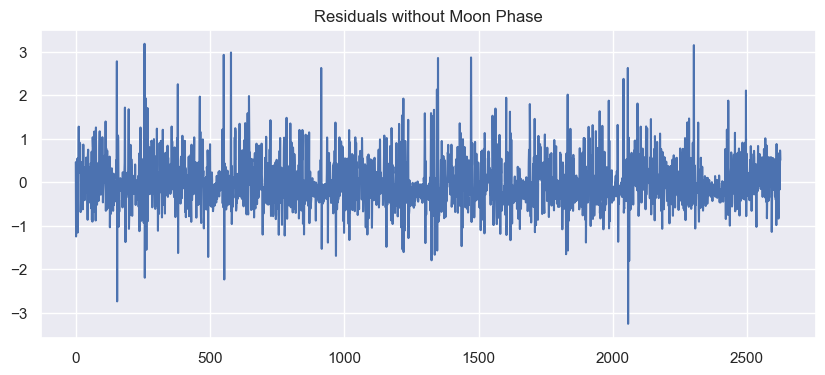

In [ ]:
# residual plot
residuals_without_mp = model_fit_without_mp.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals_without_mp)
plt.title("Residuals without Moon Phase");

### 5.4 Model Testing

#### 5.4.1 Prediction with Moon Phase

MSE of SARIMAX with Moon Phase: 0.3200066402100138


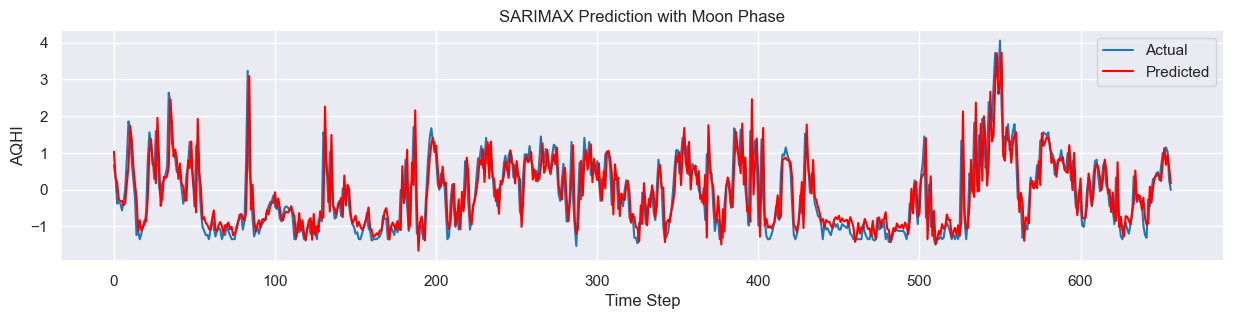

In [208]:
# predict
y_pred = model_fit.predict(start=len(X_train_df),
                           end=len(X_train_df) + len(X_test_df)-1,
                           exog=X_test_df)

mse_sarimax = mean_squared_error(y_test_df, y_pred)
print(f'MSE of SARIMAX with Moon Phase: {mse_sarimax}')

# plotting the results
plt.figure(figsize=(15, 3))

plt.plot(X_test_df.index, y_test_df, label='Actual', color='tab:blue')
plt.plot(X_test_df.index, y_pred, label='Predicted', color='red')

plt.title('SARIMAX Prediction with Moon Phase')
plt.xlabel('Time Step')
plt.ylabel('AQHI')
plt.legend()
plt.grid(True);

#### 5.4.2 Prediction without Moon Phase

MSE of SARIMAX without Moon Phase: 0.3230477189111593


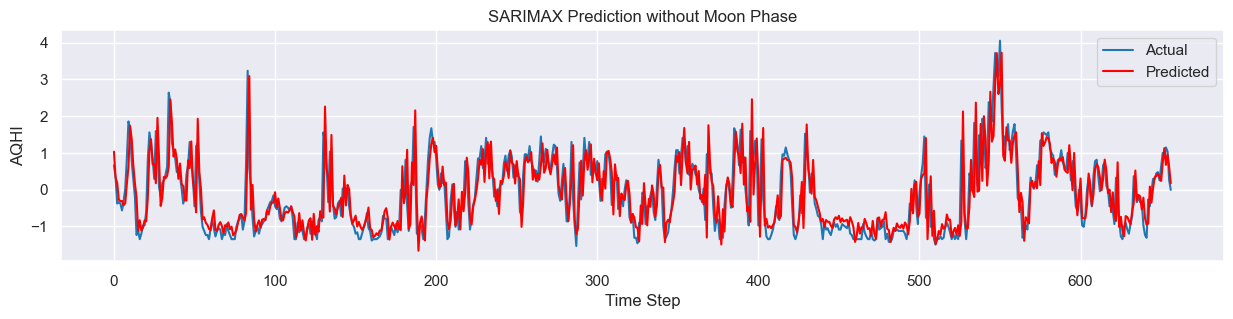

In [209]:
# predict
y_pred_without_mp = model_fit_without_mp.predict(start=len(X_train_without_mp_df),
                           end=len(X_train_without_mp_df) + len(X_test_without_mp_df)-1,
                           exog=X_test_without_mp_df)

mse_sarimax_without_mp = mean_squared_error(y_test_df, y_pred_without_mp)
print(f'MSE of SARIMAX without Moon Phase: {mse_sarimax_without_mp}')

# plotting the results
plt.figure(figsize=(15, 3))

plt.plot(X_test_without_mp_df.index, y_test_df, label='Actual', color='tab:blue')
plt.plot(X_test_without_mp_df.index, y_pred, label='Predicted', color='red')

plt.title('SARIMAX Prediction without Moon Phase')
plt.xlabel('Time Step')
plt.ylabel('AQHI')
plt.legend()
plt.grid(True);

## 6. LSTM - Deep Learning Model

### 6.1 Converting data to tensors

In [28]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

X_train_without_mp_tensor = torch.tensor(X_train_without_mp, dtype=torch.float32)
X_test_without_mp_tensor = torch.tensor(X_test_without_mp, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

### 6.2 Model Architecture

In [29]:
# define the lstm model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

### 6.3 Hyperparameter Tuning with Cross-validation

#### 6.3.1 Implement the GridSearchCV function

In [30]:
# define the function to train and evaluate the model
def train_and_evaluate(X_train_tensor, y_train_tensor,
                       X_val_tensor, y_val_tensor,
                       input_size, hidden_size, output_size, num_epochs, learning_rate):

    model = LSTMModel(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # train the model
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()  # zero gradients at the beginning of each epoch
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        loss.backward()  # backpropagation
        optimizer.step()  # update weights

    # evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X_val_tensor)
        mse = mean_squared_error(y_val_tensor.numpy(), predictions.numpy())
    return mse

In [31]:
# define the function for gridsearchCV
def grid_search_time_series(X, y, K):
    input_size = X.shape[2]  # number of features
    output_size = 1

    results = []

    # parameter grid
    input_size = X.shape[2]  # Number of features
    output_size = 1
    hidden_sizes = [10, 50, 100]
    num_epochs_list = [50, 100]
    learning_rates = [0.001, 0.01]

    # gridsearchCV
    tscv = TimeSeriesSplit(n_splits=K)
    for hidden_size, num_epochs, learning_rate in itertools.product(hidden_sizes, num_epochs_list, learning_rates):
        fold_mse = []

        for train_index, val_index in tscv.split(X):
            # split the data into training and validation sets
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # convert to tensors if not already done
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

            # train
            mse = train_and_evaluate(X_train_tensor, y_train_tensor,
                                     X_val_tensor, y_val_tensor,
                                     input_size, hidden_size, output_size,
                                     num_epochs, learning_rate)
            fold_mse.append(mse)

        # average MSE across folds
        avg_mse = np.mean(fold_mse)
        results.append((hidden_size, num_epochs, learning_rate, avg_mse))
        print(f"Hidden Size: {hidden_size}, Num Epochs: {num_epochs}, Learning Rate: {learning_rate}, Avg MSE: {avg_mse:.4f}")

    # find the best hyperparameters
    best_params = min(results, key=lambda x: x[3])  # find the minimum Avg MSE
    print(f"\nBest Parameters: Hidden Size: {best_params[0]}, Num Epochs: {best_params[1]}, Learning Rate: {best_params[2]}, Avg MSE: {best_params[3]:.4f}\n")

    return


#### 6.3.2 Model fitting with Moon Phase

In [ ]:
# compare the 5-fold cv results w/ and w/o moon phase
K = 5

print("With Moon Phase:\n")
grid_search_time_series(X, y, K)

With Moon Phase:

Hidden Size: 10, Num Epochs: 50, Learning Rate: 0.001, Avg MSE: 0.7853
Hidden Size: 10, Num Epochs: 50, Learning Rate: 0.01, Avg MSE: 0.3532
Hidden Size: 10, Num Epochs: 100, Learning Rate: 0.001, Avg MSE: 0.6304
Hidden Size: 10, Num Epochs: 100, Learning Rate: 0.01, Avg MSE: 0.3285
Hidden Size: 50, Num Epochs: 50, Learning Rate: 0.001, Avg MSE: 0.5444
Hidden Size: 50, Num Epochs: 50, Learning Rate: 0.01, Avg MSE: 0.3234
Hidden Size: 50, Num Epochs: 100, Learning Rate: 0.001, Avg MSE: 0.3967
Hidden Size: 50, Num Epochs: 100, Learning Rate: 0.01, Avg MSE: 0.4046
Hidden Size: 100, Num Epochs: 50, Learning Rate: 0.001, Avg MSE: 0.4800
Hidden Size: 100, Num Epochs: 50, Learning Rate: 0.01, Avg MSE: 0.3316
Hidden Size: 100, Num Epochs: 100, Learning Rate: 0.001, Avg MSE: 0.3508
Hidden Size: 100, Num Epochs: 100, Learning Rate: 0.01, Avg MSE: 0.4972

Best Parameters: Hidden Size: 50, Num Epochs: 50, Learning Rate: 0.01, Avg MSE: 0.3234



#### 6.3.3 Model fitting without Moon Phase

In [ ]:
print("Without Moon Phase:\n")
grid_search_time_series(X_without_mp, y, K)

Without Moon Phase:

Hidden Size: 10, Num Epochs: 50, Learning Rate: 0.001, Avg MSE: 0.8038
Hidden Size: 10, Num Epochs: 50, Learning Rate: 0.01, Avg MSE: 0.3430
Hidden Size: 10, Num Epochs: 100, Learning Rate: 0.001, Avg MSE: 0.6129
Hidden Size: 10, Num Epochs: 100, Learning Rate: 0.01, Avg MSE: 0.3176
Hidden Size: 50, Num Epochs: 50, Learning Rate: 0.001, Avg MSE: 0.5462
Hidden Size: 50, Num Epochs: 50, Learning Rate: 0.01, Avg MSE: 0.3140
Hidden Size: 50, Num Epochs: 100, Learning Rate: 0.001, Avg MSE: 0.3977
Hidden Size: 50, Num Epochs: 100, Learning Rate: 0.01, Avg MSE: 0.3607
Hidden Size: 100, Num Epochs: 50, Learning Rate: 0.001, Avg MSE: 0.4698
Hidden Size: 100, Num Epochs: 50, Learning Rate: 0.01, Avg MSE: 0.3180
Hidden Size: 100, Num Epochs: 100, Learning Rate: 0.001, Avg MSE: 0.3434
Hidden Size: 100, Num Epochs: 100, Learning Rate: 0.01, Avg MSE: 0.4358

Best Parameters: Hidden Size: 50, Num Epochs: 50, Learning Rate: 0.01, Avg MSE: 0.3140



The optimal hyperparameters:
- With moon phase -> Hidden Size: 50, Num Epochs: 50, Learning Rate: 0.01, Avg MSE: 0.3234
- Without moon phase -> Hidden Size: 50, Num Epochs: 50, Learning Rate: 0.01, Avg MSE: 0.3140

### 6.4 Model Testing

#### 6.4.1 Prediction with Moon Phase

Epoch [10/50], Train Loss: 0.4600, Test Loss: 0.4014
Epoch [20/50], Train Loss: 0.3613, Test Loss: 0.3192
Epoch [30/50], Train Loss: 0.3153, Test Loss: 0.2884
Epoch [40/50], Train Loss: 0.3029, Test Loss: 0.2886
Epoch [50/50], Train Loss: 0.2929, Test Loss: 0.2891


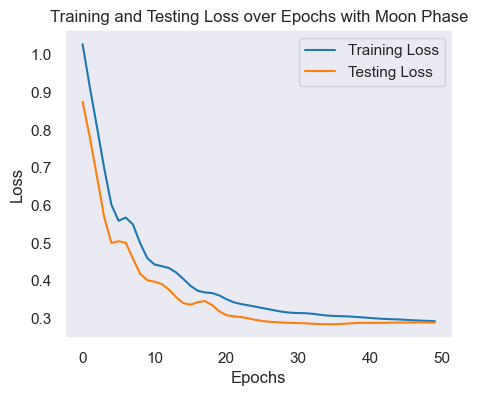

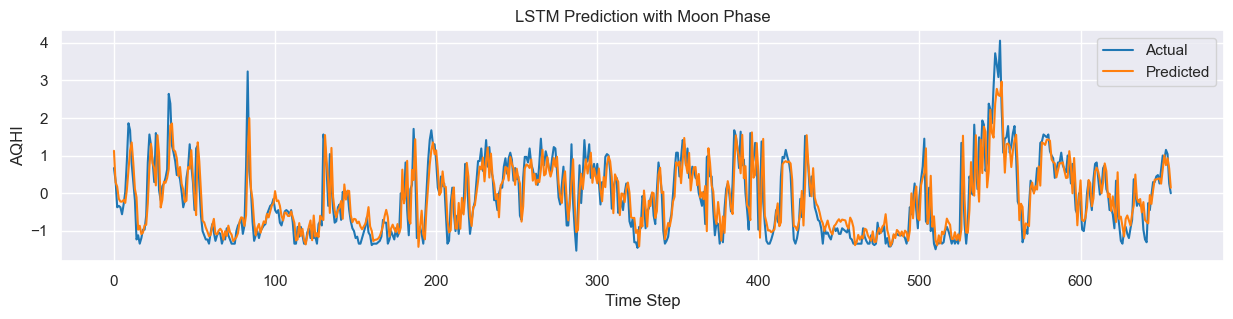

In [ ]:
# 1. test the tuned model with optimal hyperparameters
# 2. visualize the train-test loss -> to see if there are any signs of overfitting
# 3. visualize the prediction

# The optimal hyperparameters:
# - With moon phase -> hidden layers: 50, epoches: 50, learning rate: 0.01

# hyperparameters
hidden_size = 50
num_epochs = 50
learning_rate = 0.01

# model, loss function, and optimizer
input_size = X.shape[2]
output_size = 1

model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# lists to store losses
train_losses = []
test_losses = []

# train
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # forward pass
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)

    # backward pass
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # store the data to plot the training and testing loss
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# test
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    y_pred = predictions.numpy()

# plot the training and testing loss
plt.figure(figsize=(5, 4))
plt.plot(train_losses, label='Training Loss', color='tab:blue')
plt.plot(test_losses, label='Testing Loss', color='tab:orange')
plt.title('Training and Testing Loss over Epochs with Moon Phase')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# visualize the predictions
plt.figure(figsize=(15, 3))
plt.plot(y_test, label='Actual', color='tab:blue')
plt.plot(y_pred, label='Predicted', color='tab:orange')
plt.title('LSTM Prediction with Moon Phase')
plt.xlabel('Time Step')
plt.ylabel('AQHI')
plt.legend()
plt.show()

#### 6.4.2 Prediction without Moon Phase

Epoch [10/50], Train Loss: 0.4453, Test Loss: 0.3890
Epoch [20/50], Train Loss: 0.3469, Test Loss: 0.3031
Epoch [30/50], Train Loss: 0.3167, Test Loss: 0.2876
Epoch [40/50], Train Loss: 0.3057, Test Loss: 0.2875
Epoch [50/50], Train Loss: 0.2982, Test Loss: 0.2912


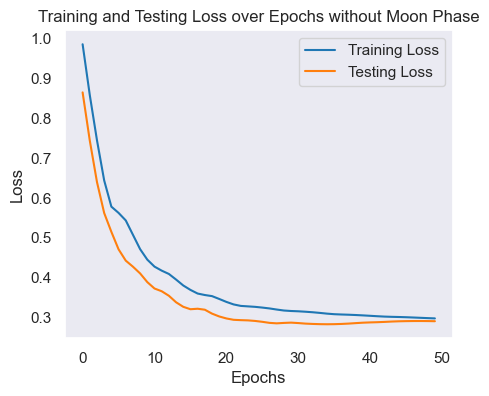

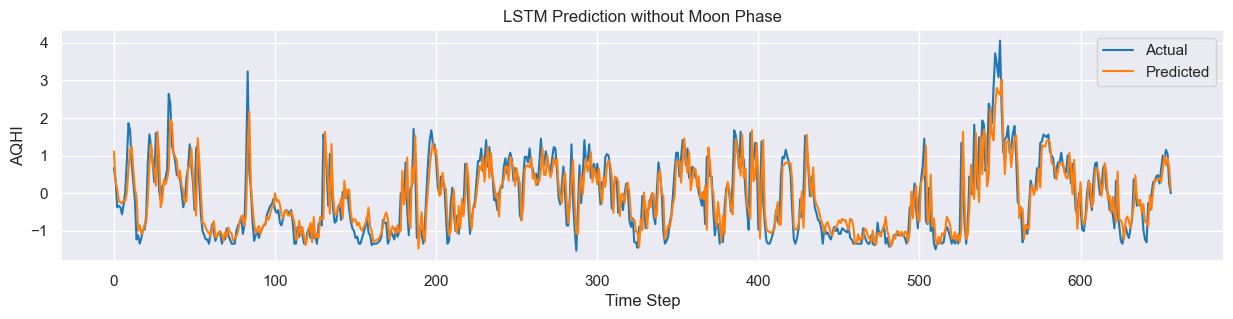

In [ ]:
# 1. test the tuned model with optimal hyperparameters
# 2. visualize the train-test loss -> to see if there are any signs of overfitting
# 3. visualize the prediction

# The optimal hyperparameters:
# - Without moon phase -> hidden layers: 100, epoches: 50, learning rate: 0.01

# hyperparameters
hidden_size = 50
num_epochs = 50
learning_rate = 0.01

# model, loss function, and optimizer
input_size = X.shape[2]-1
output_size = 1

model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# lists to store losses
train_losses = []
test_losses = []

# train
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # forward pass
    outputs = model(X_train_without_mp_tensor)
    train_loss = criterion(outputs, y_train_tensor)

    # backward pass
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # store the data to plot the training and testing loss
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_without_mp_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# test
model.eval()
with torch.no_grad():
    predictions = model(X_test_without_mp_tensor)
    y_pred = predictions.numpy()

# plot the training and testing loss
plt.figure(figsize=(5, 4))
plt.plot(train_losses, label='Training Loss', color='tab:blue')
plt.plot(test_losses, label='Testing Loss', color='tab:orange')
plt.title('Training and Testing Loss over Epochs without Moon Phase')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# visualize the predictions
plt.figure(figsize=(15, 3))
plt.plot(y_test, label='Actual', color='tab:blue')
plt.plot(y_pred, label='Predicted', color='tab:orange')
plt.title('LSTM Prediction without Moon Phase')
plt.xlabel('Time Step')
plt.ylabel('AQHI')
plt.legend()
plt.show()

## 7. Conclusion

### 7.1 Performance Comparison

### 7.2 Limitations

- Data Size: Our analysis is restricted to data from 2014 to 2022, as the data for 2023 and 2024 is 
incomplete, which could lead to inconsistencies in the time frame. Additionally, only partial data is 
available for 2013 due to the transition at HKEPD from the old Air Pollution Index to a more health-
focused Air Quality Health Index (AQHI). 

- Moon Phase: The moon phase feature lacks sufficient detailed variation (with only four different 
variations), which may limit its effectiveness as a predictor in the modeling process.

- Limited Computational Power: As noted previously, our ability to test different sequence lengths 
and conduct extensive hyperparameter tuning is constrained by limited computational resources. 

### 7.3 Improvement

- Utilize More Features: To enhance the model's predictive capabilities, it is important to explore and 
incorporate additional features that may provide valuable insights and improve accuracy. This could 
include variables such as wind speed, rainfall or Hong Kong Heat Index. 

- Utilize Data from Other Monitoring Stations: Incorporating data from surrounding monitoring 
stations would also facilitate a better understanding of regional variations and enhance the overall 
robustness of the model. 

- More Detailed Moon Phase Variations: To further investigate the effectiveness of the moon phase 
feature, it is essential to obtain more detailed variations of moon phases. For example, expanding the 
data from the current four primary phases to the more conventional eight-phase system

### 7.4 Summary